In [1]:
import operator
import random
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
from deap import gp
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report
import numpy as np
import pandas as pd
from functools import partial
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("./wdbc.data", header=None)

In [3]:
X = df.iloc[:, 2:]

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2       569 non-null    float64
 1   3       569 non-null    float64
 2   4       569 non-null    float64
 3   5       569 non-null    float64
 4   6       569 non-null    float64
 5   7       569 non-null    float64
 6   8       569 non-null    float64
 7   9       569 non-null    float64
 8   10      569 non-null    float64
 9   11      569 non-null    float64
 10  12      569 non-null    float64
 11  13      569 non-null    float64
 12  14      569 non-null    float64
 13  15      569 non-null    float64
 14  16      569 non-null    float64
 15  17      569 non-null    float64
 16  18      569 non-null    float64
 17  19      569 non-null    float64
 18  20      569 non-null    float64
 19  21      569 non-null    float64
 20  22      569 non-null    float64
 21  23      569 non-null    float64
 22  24

In [5]:
y = df.iloc[:, 1]

In [6]:
le = LabelEncoder()

In [7]:
y = le.fit_transform(y)

In [8]:
np.unique(y)

array([0, 1])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
print(X_train.shape, X_test.shape)

(426, 30) (143, 30)


In [11]:
print(y_train.shape, y_test.shape)

(426,) (143,)


In [12]:
def eaSimple(
    population,
    toolbox,
    cxpb,
    mutpb,
    ngen,
    stats=None,
    halloffame=None,
    verbose=__debug__,
    use_varAnd=True,
):
    logbook = tools.Logbook()
    logbook.header = ["gen", "nevals"] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        if use_varAnd:
            offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)
        else:
            offspring = algorithms.varOr(
                offspring, toolbox, len(offspring), cxpb, mutpb
            )

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [13]:
def evaluate(individual, toolbox):
    func = toolbox.compile(expr=individual)
    y_pred = [func(*data) for _, data in X_train.iterrows()]
    y_labels = np.unique(y)
    y_pred = list(map(lambda x: y_labels[0] if x > 0 else y_labels[1], y_pred))
    tmp = random.random()
    ret =  tmp * accuracy_score(y_train, y_pred) + (1 - tmp) * f1_score(
        y_train, y_pred
    )
    return ret,

In [14]:
# Use iloc instead of directly indexing like X[col][0] as the indices will shuffled during train_test_split
pset = gp.PrimitiveSetTyped("main", [type(X_train[col].iloc[0]) for col in X_train], np.float64, "IN")

In [15]:
def protected_div(left, right):
    if right != 0:
        return np.float64(left / right)
    else:
        return np.float64(1)
pset.addPrimitive(operator.add, [np.float64, np.float64], np.float64)
pset.addPrimitive(operator.sub, [np.float64, np.float64], np.float64)
pset.addPrimitive(operator.mul, [np.float64, np.float64], np.float64)
pset.addPrimitive(protected_div, [np.float64, np.float64], np.float64)
# Add this constant to prevent no primitive found error
# This occurs because there may be an odd number of inputs and all the functions are binary
pset.addEphemeralConstant(name="RAND", ephemeral=partial(np.float64, random.random()), ret_type=np.float64)

In [16]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

In [17]:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

In [18]:
toolbox = base.Toolbox()

In [19]:
toolbox.register("expr", gp.genFull, pset=pset, min_=2, max_=7)

In [20]:
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)

In [21]:
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [22]:
toolbox.register("compile", gp.compile, pset=pset)

In [23]:
toolbox.register(
    "evaluate",
    evaluate,
    toolbox=toolbox,
)

In [24]:
toolbox.register("select", tools.selTournament, tournsize=6)

In [25]:
toolbox.register("mate", gp.cxOnePoint)

In [26]:
toolbox.register("expr_mut", gp.genFull, min_=2, max_=6)

In [27]:
# toolbox.register("mutate", gp.mutShrink)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

In [28]:
use_varAnd = True
cxpb = 0
mutpb = 1

In [29]:
pop = toolbox.population(100)

In [30]:
hof = tools.HallOfFame(1)

In [31]:
stats = tools.Statistics(lambda ind: ind.fitness.values)

In [32]:
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [33]:
pop, log = eaSimple(
    pop,
    toolbox,
    cxpb=cxpb,
    mutpb=mutpb,
    ngen=200,
    stats=stats,
    halloffame=hof,
    verbose=True,
    use_varAnd=use_varAnd
)

gen	nevals	avg     	std     	min       	max     
0  	100   	0.380621	0.173657	0.00232652	0.813746
1  	100   	0.446114	0.189307	0.00568119	0.838946
2  	100   	0.554248	0.198497	0.0926042 	0.864538
3  	100   	0.601946	0.235058	0.0319359 	0.881162
4  	100   	0.691111	0.227534	0.0542434 	0.879   
5  	100   	0.663273	0.256436	0.0533643 	0.887098
6  	100   	0.744093	0.222984	0.0559317 	0.899484
7  	100   	0.715798	0.256399	0.0508227 	0.898893
8  	100   	0.726972	0.272195	0.0715066 	0.919376
9  	100   	0.764107	0.233857	0.0875685 	0.923627
10 	100   	0.795734	0.202348	0.101367  	0.923236
11 	100   	0.767468	0.232482	0.036311  	0.924585
12 	100   	0.75576 	0.242681	0.077695  	0.932666
13 	100   	0.822999	0.185592	0.0736508 	0.936353
14 	100   	0.829164	0.179947	0.192051  	0.935798
15 	100   	0.815406	0.197668	0.0624624 	0.937392
16 	100   	0.810439	0.20982 	0.0455173 	0.952268
17 	100   	0.839433	0.181478	0.165329  	0.951872
18 	100   	0.809329	0.209387	0.0826472 	0.952808
19 	100   	0.846993	

KeyboardInterrupt: 

In [34]:
def test(individual, toolbox=toolbox):
    func = toolbox.compile(expr=individual)
    y_pred = [func(*data) for _, data in X_test.iterrows()]
    y_labels = np.unique(y)
    y_pred = list(map(lambda x: y_labels[0] if x > 0 else y_labels[1], y_pred))
    return accuracy_score(y_test, y_pred)

In [35]:
final_ind = hof[0]

In [36]:
test(final_ind)

0.951048951048951

In [37]:
final_ind_graph= gp.graph(final_ind)

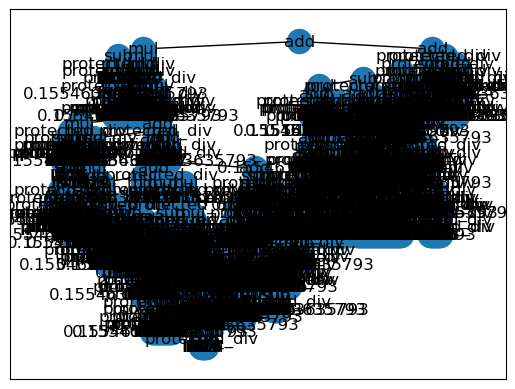

In [38]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

nodes, edges, labels = gp.graph(final_ind)

g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = graphviz_layout(g, prog="dot")

nx.draw_networkx_nodes(g, pos)
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels)
plt.show()

In [39]:
import pygraphviz as pgv

g = pgv.AGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]

g.draw("tree.pdf")